In [119]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
!pip install graphviz
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from graphviz import Source
import matplotlib.pyplot as plt
!pip install pydot

In [120]:
DATA_DIR = "/home/jovyan/work"
TRAIN_FILE = f"{DATA_DIR}/german_credit_data.csv"
TEST_FILE = f"{DATA_DIR}/german_test_data.csv"
MODIFIED_TRAIN_FILE = f"{DATA_DIR}/german_credit_data_modified.csv"
MODIFIED_TEST_FILE = f"{DATA_DIR}/german_test_data_modified.csv"
DOT_FILE = f"{DATA_DIR}/loan_risk.dot"
DOT_FILE_MODIFIED = f"{DATA_DIR}/loan_risk_modified.dot"

In [121]:
def train_decision_tree(X, y, max_depth=3, random_state=42):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=random_state)
    clf.fit(X, y)
    return clf

def evaluate_model(y_true, y_pred, pos_label="good"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos_label)
    rec = recall_score(y_true, y_pred, pos_label=pos_label)
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, cm

In [122]:
def load_data(file_path):
    return pd.read_csv(file_path)

def save_data(df, file_path):
    df.to_csv(file_path, index=False)

In [123]:
def export_and_show_tree(tree_clf, dot_file, feature_names, class_names):
    export_graphviz(
        tree_clf,
        out_file=dot_file,
        feature_names=feature_names,
        class_names=class_names,
        rounded=True,
        filled=True
    )
    return Source.from_file(dot_file)

In [124]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

def run_grid_search(X, y, param_grid, test_size=0.2, random_state=42, cv=5, scoring='accuracy'):
    """
    Splits data, runs GridSearchCV, prints best parameters and classification report.
    Returns best model and test data.
    """
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Define the model
    dt = DecisionTreeClassifier(random_state=random_state)
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=1, scoring=scoring)
    
    # Fit to training data
    grid_search.fit(X_train, y_train)
    
    # Print best parameters
    print("Best Parameters:", grid_search.best_params_)
    
    # Use best model to make predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Evaluate performance
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return best_model, X_test, y_test, y_pred


In [125]:
# Load data
train_df = load_data(TRAIN_FILE)
test_df = load_data(TEST_FILE)

# Prepare features and target
X_train = train_df[["Duration", "Credit amount"]]
y_train = train_df["Risk"]
X_test = test_df[["Duration", "Credit amount"]]
y_test = test_df["Target"]
X_test_again = test_df[["Duration", "Credit amount","Installment rate"]]

# Train model
print("Training a Decision Tree classifier")
tree_clf = train_decision_tree(X_train, y_train)

from sklearn.model_selection import cross_val_score
tree_accurancy_score = cross_val_score(tree_clf, X_train, y_train, cv=10, scoring="accuracy")
print("\nChecking the cross validation score of Decision Tree classifier:\n")
print(tree_accurancy_score)

from sklearn.dummy import DummyClassifier

print("\nTraining a dummy classifier\n")
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_clf_score= cross_val_score(dummy_clf, X_train, y_train, cv=10, scoring="accuracy")
print("Checking the cross validation score of dummy classifier:\n")
print(dummy_clf_score)

# Predict and evaluate
y_train_pred = tree_clf.predict(X_train)
train_df["Predicted"] = y_train_pred
save_data(train_df, MODIFIED_TRAIN_FILE)

acc, prec, rec, cm = evaluate_model(y_train, y_train_pred)
print(f"\n Train Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")
print("Confusion Matrix:\n", cm)

DOT_TRAIN = export_and_show_tree(
    tree_clf,
    DOT_FILE,
    ["Duration", "Credit amount"],
    tree_clf.classes_
)
# Test predictions
y_test_pred = tree_clf.predict(X_test)
test_df["Predicted"] = y_test_pred
save_data(test_df, MODIFIED_TEST_FILE)

acc_test, prec_test, rec_test, cm_test = evaluate_model(y_test, y_test_pred)
print(f"Test Accuracy: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}")
print("Test Confusion Matrix:\n", cm_test)

#Retrain model
tree_clf = train_decision_tree(X_test_again, y_test)
# Predict and evaluate
y_test_pred_again = tree_clf.predict(X_test_again)
test_df["Predicted"] = y_train_pred_again
save_data(train_df, MODIFIED_TEST_FILE)

# For three features
MODIFIED_DOT= export_and_show_tree(
    tree_clf,
    DOT_FILE_MODIFIED,
    ["Duration", "Credit amount", "Installment rate"],
    tree_clf.classes_
)
acc_test, prec_test, rec_test, cm_test = evaluate_model(y_test, y_test_pred_again)
print(f"Test Accuracy: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}")
print("Test Confusion Matrix:\n", cm_test)

Training a Decision Tree classifier

Checking the cross validation score of Decision Tree classifier:

[0.73 0.66 0.72 0.73 0.71 0.7  0.66 0.68 0.61 0.75]

Training a dummy classifier

Checking the cross validation score of dummy classifier:

[0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7]

 Train Accuracy: 0.72, Precision: 0.73, Recall: 0.96
Confusion Matrix:
 [[ 55 245]
 [ 30 670]]
Test Accuracy: 0.45, Precision: 0.47, Recall: 0.70
Test Confusion Matrix:
 [[2 8]
 [3 7]]
Test Accuracy: 0.85, Precision: 0.77, Recall: 1.00
Test Confusion Matrix:
 [[ 7  3]
 [ 0 10]]


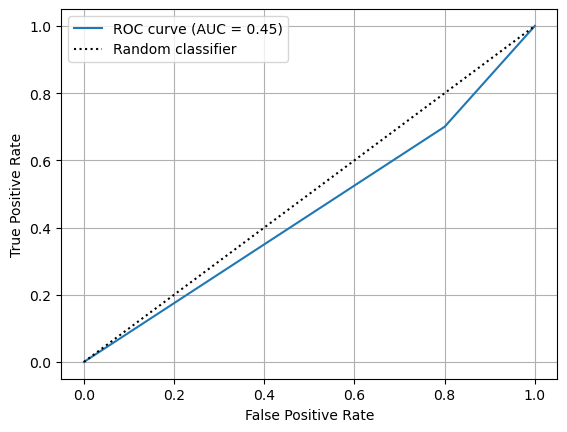

Test ROC AUC: 0.45


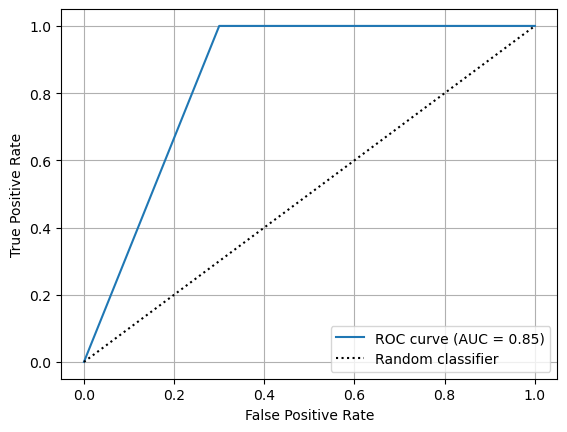

Test ROC AUC with installment rate: 0.85


In [126]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

def plot_roc_curve(y_true, y_pred):
    le = LabelEncoder()
    y_true_enc = le.fit_transform(y_true)
    y_pred_enc = le.transform(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true_enc, y_pred_enc)
    auc = roc_auc_score(y_true_enc, y_pred_enc)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k:', label="Random classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()
    return auc

auc = plot_roc_curve(y_test, y_test_pred)
print(f"Test ROC AUC: {auc:.2f}")

auc = plot_roc_curve(y_test, y_test_pred_again)
print(f"Test ROC AUC with installment rate: {auc:.2f}")


In [127]:
DOT_TRAIN

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [128]:
MODIFIED_DOT

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [129]:
# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Example 1: Two features
X = train_df[["Duration", "Credit amount"]]
y = train_df["Risk"]
best_model_2feat, X_test_2feat, y_test_2feat, y_pred_2feat = run_grid_search(X, y, param_grid)

# Example 2: Three features
X = test_df[["Duration", "Credit amount", "Installment rate"]]
y = test_df["Target"]
best_model_3feat, X_test_3feat, y_test_3feat, y_pred_3feat = run_grid_search(X, y, param_grid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

         bad       0.38      0.08      0.14        59
        good       0.71      0.94      0.81       141

    accuracy                           0.69       200
   macro avg       0.55      0.51      0.47       200
weighted avg       0.61      0.69      0.61       200

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

         bad       0.75      1.00      0.86         3
        good       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg     

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
